# Static Schedule Baseline Analysis

This notebook establishes the "Common Sense Baseline" for our Headway Prediction Model.
We calculate the *Scheduled Headway* using GTFS Static data to see how well a perfect schedule adherence would predict arrival times.
If our ML model cannot beat this baseline, it is not adding value.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import sys

# Set style
sns.set_style("whitegrid")

# Verify data path
DATA_DIR = '../mlops_pipeline/data/gtfs_static'
if not os.path.exists(DATA_DIR):
    print(f"WARNING: Data directory {DATA_DIR} not found.")
    print("Files found in current dir:")
    print(os.listdir('.'))
else:
    print(f"Data directory found: {DATA_DIR}")
    print("GTFS Files:", os.listdir(DATA_DIR))

Data directory found: ../mlops_pipeline/data/gtfs_static
GTFS Files: ['transfers.txt', 'agency.txt', 'calendar_dates.txt', 'stop_times.txt', 'gtfs.zip', 'shapes.txt', 'trips.txt', 'stops.txt', 'calendar.txt', 'routes.txt']


In [2]:
# Load GTFS Files
# We only need specific files for schedule reconstruction
print("Loading GTFS text files...")
try:
    trips = pd.read_csv(f'{DATA_DIR}/trips.txt')
    stop_times = pd.read_csv(f'{DATA_DIR}/stop_times.txt')
    calendar = pd.read_csv(f'{DATA_DIR}/calendar.txt', parse_dates=['start_date', 'end_date'])
    calendar_dates = pd.read_csv(f'{DATA_DIR}/calendar_dates.txt', parse_dates=['date'])
    stops = pd.read_csv(f'{DATA_DIR}/stops.txt')
    
    print("Files loaded successfully.")
    print(f"Trips: {trips.shape}")
    print(f"Stop Times: {stop_times.shape}")
except Exception as e:
    print(f"Error loading files: {e}")

Loading GTFS text files...
Files loaded successfully.
Trips: (20304, 6)
Stop Times: (562597, 5)


In [3]:
# Target Stop Configuration
TARGET_STOP_ID = 'A32S'

# Verify Stop Exists
stop_info = stops[stops['stop_id'] == TARGET_STOP_ID]
print(f"Target Stop Info:\n{stop_info}")

# Filter stop_times for this stop
st_filtered = stop_times[stop_times['stop_id'] == TARGET_STOP_ID].copy()

# Join with trips to get Route ID and Service ID
df_sched = pd.merge(st_filtered, trips[['trip_id', 'route_id', 'service_id']], on='trip_id')

print(f"\nFiltered Schedule Rows: {len(df_sched)}")
print(f"Unique Routes: {df_sched['route_id'].unique()}")
df_sched.head()

Target Stop Info:
    stop_id       stop_name   stop_lat   stop_lon  location_type  \
608    A32S  W 4 St-Wash Sq  40.732338 -74.000495            NaN   

    parent_station  
608            A32  

Filtered Schedule Rows: 1095
Unique Routes: ['A' 'C' 'E']


,trip_id,stop_id,arrival_time,departure_time,stop_sequence,route_id,service_id
0,BFA25GEN-A047-Saturday-00_001150_A..S74R,A32S,00:49:00,00:49:00,25,A,Saturday
1,BFA25GEN-A047-Saturday-00_002950_A..S74R,A32S,01:08:30,01:08:30,25,A,Saturday
2,BFA25GEN-A047-Saturday-00_004950_A..S74R,A32S,01:28:30,01:28:30,25,A,Saturday
3,BFA25GEN-A047-Saturday-00_006950_A..S74R,A32S,01:48:30,01:48:30,25,A,Saturday
4,BFA25GEN-A047-Saturday-00_008950_A..S74R,A32S,02:08:30,02:08:30,25,A,Saturday


In [8]:

# -------------------------------------------------------------
# STEP 1.5: FETCH REAL-TIME DATA TO DEFINE SCHEDULE WINDOW
# -------------------------------------------------------------
from google.cloud import bigquery

print("Fetching full event history to determine Test Set range...")
# Identify Project ID
PROJECT_ID = 'realtime-headway-prediction'
client = bigquery.Client(project=PROJECT_ID)

# Fetch columns needed for split & alignment
query = f"""
    SELECT
        arrival_time,
        route_id,
        ROUND(headway, 2) AS actual_headway_min,
        time_of_day_seconds
    FROM `{PROJECT_ID}.headway_prediction.ml`
    WHERE track = 'A1'
    AND route_id IN ('A', 'C', 'E')
    ORDER BY arrival_time
"""

df_all = client.query(query).to_dataframe()
df_all['arrival_time'] = pd.to_datetime(df_all['arrival_time'])

print(f"Original Time Zone sample: {df_all['arrival_time'].iloc[0]}")

# Convert to 'US/Eastern' to match the naive GTFS schedule (NYC Time)
# Then strip timezone info so everything is Naive and compatible
df_all['arrival_time'] = df_all['arrival_time'].dt.tz_convert('US/Eastern').dt.tz_localize(None)

# ensure sorted
df_all = df_all.sort_values('arrival_time')

# Split 80/20
split_idx = int(len(df_all) * 0.8)
df_test = df_all.iloc[split_idx:].copy()

print(f"Total Rows: {len(df_all)}")
print(f"Test Set Size: {len(df_test)} (Last 20%)")

# Define Schedule Window based on Test Set
# We want to generate the schedule for the exact days present in the test set
TEST_START_DATE = df_test['arrival_time'].min().normalize()
TEST_END_DATE = df_test['arrival_time'].max().normalize() + pd.Timedelta(days=1)

print(f"Dynamic Schedule Window (Local Time): {TEST_START_DATE.date()} to {TEST_END_DATE.date()}")
df_test.head()

Fetching full event history to determine Test Set range...
Original Time Zone sample: 2025-07-18 08:53:57+00:00
Total Rows: 51752
Test Set Size: 10351 (Last 20%)
Dynamic Schedule Window (Local Time): 2025-12-14 to 2026-01-20


,arrival_time,route_id,actual_headway_min,time_of_day_seconds
41401,2025-12-14 14:40:09,C,2.35,52809
41402,2025-12-14 14:42:11,E,2.03,52931
41403,2025-12-14 14:53:14,C,11.05,53594
41404,2025-12-14 14:55:29,E,2.25,53729
41405,2025-12-14 15:03:48,A,8.32,54228


In [9]:

# --- Schedule Expansion Logic ---
# Converts abstract 'service_ids' into concrete timestamps for the TEST SET window

# Use the dynamic window derived from the Test Set
START_DATE = TEST_START_DATE
END_DATE = TEST_END_DATE

# 1. Helper to parse GTFS time strings "HH:MM:SS" (which can be > 24:00:00)
def gtfs_time_to_seconds(t_str):
    parts = t_str.split(':')
    return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])

df_sched['arrival_seconds'] = df_sched['arrival_time'].apply(gtfs_time_to_seconds)

# 2. Build Daily Schedule
schedule_rows = []
date_range = pd.date_range(start=START_DATE, end=END_DATE)

print(f"Generating concrete schedule for {START_DATE.date()} to {END_DATE.date()}...")

for d in date_range:
    day_of_week = d.dayofweek # 0=Mon, 6=Sun
    
    # Identify active services for this specific day
    active_services = set()
    
    # Check regular Weekly Schedule
    for _, row in calendar.iterrows():
        if row['start_date'] <= d <= row['end_date']:
            # Days flags: monday, tuesday, etc.
            days = [row['monday'], row['tuesday'], row['wednesday'], row['thursday'], 
                    row['friday'], row['saturday'], row['sunday']]
            if days[day_of_week] == 1:
                active_services.add(row['service_id'])
    
    # Apply Exceptions (calendar_dates.txt)
    # Type 1 = Add service, Type 2 = Remove service
    exceptions = calendar_dates[calendar_dates['date'] == d]
    
    for _, row in exceptions.iterrows():
        if row['exception_type'] == 1:
            active_services.add(row['service_id'])
        elif row['exception_type'] == 2:
            active_services.discard(row['service_id'])
            
    if not active_services:
        continue
        
    # Get trips for active services
    daily_trips = df_sched[df_sched['service_id'].isin(active_services)].copy()
    
    if daily_trips.empty:
        continue
        
    # Create Timestamp
    # timestamp = Date + Arrival Seconds
    # Handle >24h wrap
    daily_trips['timestamp'] = d + pd.to_timedelta(daily_trips['arrival_seconds'], unit='s')
    
    schedule_rows.append(daily_trips[['timestamp', 'route_id', 'arrival_seconds']])

# Concatenate all days
full_schedule = pd.concat(schedule_rows).sort_values('timestamp').reset_index(drop=True)
print(f"Generated {len(full_schedule)} scheduled arrivals.")
full_schedule.head()


Generating concrete schedule for 2025-12-14 to 2026-01-20...
Generated 15942 scheduled arrivals.


,timestamp,route_id,arrival_seconds
0,2025-12-14 00:48:30,A,2910
1,2025-12-14 01:03:30,E,3810
2,2025-12-14 01:08:30,A,4110
3,2025-12-14 01:23:30,E,5010
4,2025-12-14 01:28:30,A,5310


In [10]:
# --- Calculate Scheduled Headway ---
# Headway = Time(Train N) - Time(Train N-1)

full_schedule['prev_timestamp'] = full_schedule['timestamp'].shift(1)
full_schedule['scheduled_headway_sec'] = (full_schedule['timestamp'] - full_schedule['prev_timestamp']).dt.total_seconds()
full_schedule['scheduled_headway_min'] = full_schedule['scheduled_headway_sec'] / 60.0

# Extract Hour for Analysis
full_schedule['hour_of_day'] = full_schedule['timestamp'].dt.hour

# Filter outliers (overnight gaps, etc.)
# Real subway headways are usually < 30 mins
full_schedule_clean = full_schedule[full_schedule['scheduled_headway_min'] < 60].copy()

print("Headway Stats (Minutes):")
print(full_schedule_clean['scheduled_headway_min'].describe())

Headway Stats (Minutes):
count    15941.000000
mean         3.432438
std          2.923869
min          0.000000
25%          1.500000
50%          2.500000
75%          4.000000
max         15.000000
Name: scheduled_headway_min, dtype: float64


/var/folders/f1/dmgdbt5j5nb5ht5_vfxmr8gm0000gn/T/ipykernel_31527/202108133.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour_of_day', y='scheduled_headway_min', data=full_schedule_clean, palette="viridis")


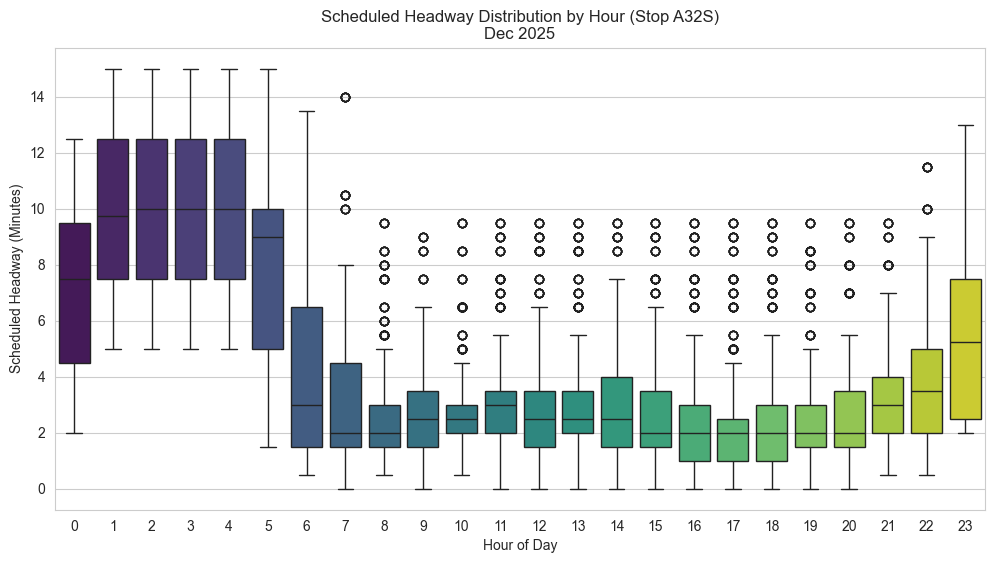

In [11]:
# --- Visualization: Expected Headway by Hour ---

plt.figure(figsize=(12, 6))
sns.boxplot(x='hour_of_day', y='scheduled_headway_min', data=full_schedule_clean, palette="viridis")
plt.title(f"Scheduled Headway Distribution by Hour (Stop {TARGET_STOP_ID})\nDec 2025")
plt.xlabel("Hour of Day")
plt.ylabel("Scheduled Headway (Minutes)")
plt.show()

aligning actual arrivals (TEST SET) with scheduled regime...

=== COMMON SENSE BASELINE RESULTS (TEST SET) ===
Mean Absolute Error (MAE): 2.8999 minutes
Root Mean Squared Error (RMSE): 4.1172 minutes
Sample Size: 10351


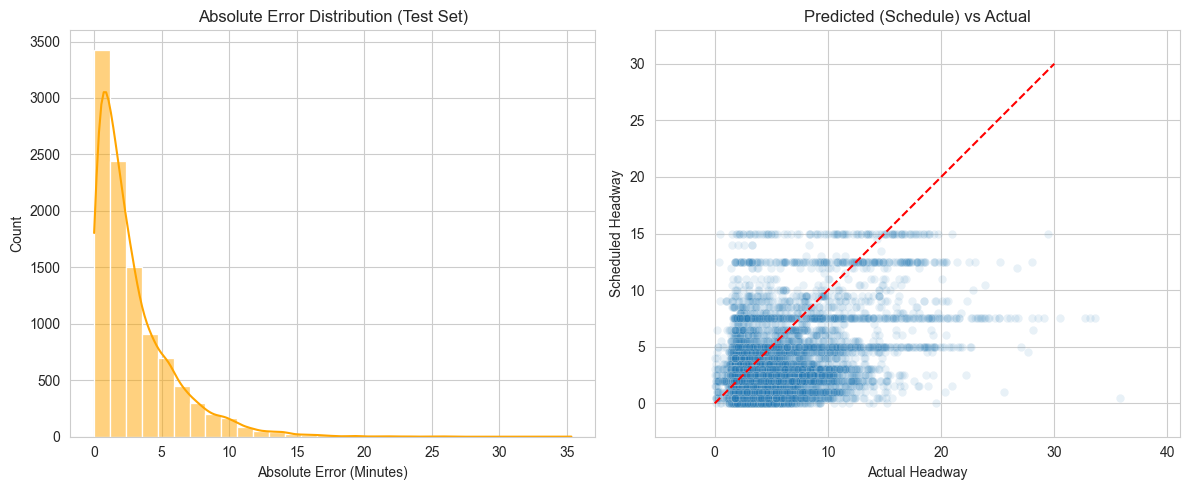

In [13]:

# -------------------------------------------------------------
# STEP 3: PERFORM ALIGNMENT & CALCULATE ERROR
# -------------------------------------------------------------

# CASTING: Ensure both timestamps have identical precision (ns vs us issue)
df_test['arrival_time'] = df_test['arrival_time'].astype('datetime64[ns]')
full_schedule['timestamp'] = full_schedule['timestamp'].astype('datetime64[ns]')

# Ensure sorting
full_schedule = full_schedule.sort_values('timestamp')
df_test = df_test.sort_values('arrival_time')

print("aligning actual arrivals (TEST SET) with scheduled regime...")

# strict_merge: For each actual arrival, look up the scheduled headway 
# based on the most recent scheduled train (direction='backward')
baseline_comparison = pd.merge_asof(
    df_test, 
    full_schedule[['timestamp', 'scheduled_headway_min']], 
    left_on='arrival_time', 
    right_on='timestamp', 
    direction='backward'
)

# Drop NaNs (if any early arrivals have no schedule)
baseline_comparison = baseline_comparison.dropna(subset=['scheduled_headway_min'])

# Calculate Error
# Prediction = Scheduled Headway
# Ground Truth = Actual Headway
baseline_comparison['baseline_prediction'] = baseline_comparison['scheduled_headway_min']
baseline_comparison['error'] = baseline_comparison['actual_headway_min'] - baseline_comparison['baseline_prediction']
baseline_comparison['abs_error'] = baseline_comparison['error'].abs()

mae = baseline_comparison['abs_error'].mean()
rmse = np.sqrt((baseline_comparison['error'] ** 2).mean())

print(f"\n=== COMMON SENSE BASELINE RESULTS (TEST SET) ===")
print(f"Mean Absolute Error (MAE): {mae:.4f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} minutes")
print(f"Sample Size: {len(baseline_comparison)}")

# Visualization of Error
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(baseline_comparison['abs_error'], bins=30, kde=True, color='orange')
plt.title("Absolute Error Distribution (Test Set)")
plt.xlabel("Absolute Error (Minutes)")

plt.subplot(1, 2, 2)
sns.scatterplot(x='actual_headway_min', y='baseline_prediction', data=baseline_comparison, alpha=0.1)
plt.plot([0, 30], [0, 30], 'r--')
plt.title("Predicted (Schedule) vs Actual")
plt.xlabel("Actual Headway")
plt.ylabel("Scheduled Headway")
plt.axis('equal')

plt.tight_layout()
plt.show()